## Using ReduceLROnPlateau

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statistics

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler

In [2]:
reuters = tf.keras.datasets.reuters       # keras datasets

(x_train, y_train), (x_test, y_test) = reuters.load_data()

2121728/2110848 [==============================] - 0s 0us/step


In [ ]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((8982,), (8982,), (2246,), (2246,))

In [ ]:
np.unique(y_train)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

In [ ]:
x_train[:2]

array([list([1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]),
       list([1, 3267, 699, 3434, 2295, 56, 16784, 7511, 9, 56, 3906, 1073, 81, 5, 1198, 57, 366, 737, 132, 20, 4093, 7, 19261, 49, 2295, 13415, 1037, 3267, 699, 3434, 8, 7, 10, 241, 16, 855, 129, 231, 783, 5, 4, 587, 2295, 13415, 30625, 775, 7, 48, 34, 191, 44, 35, 1795, 505, 17, 12])],
      dtype=object)

In [ ]:
y_train[:2]

array([3, 4])

In [ ]:
# finding max, avg, median length of sentences

sentence_len = []

for sentence in x_train:
    sentence_len.append(len(sentence))

print(max(sentence_len))
print(sum(sentence_len)/len(sentence_len))
print(statistics.median(sentence_len))

2376
145.5398574927633
95.0


In [ ]:
# finding number of unique elements in full text

unique_ele = []

for sentence in x_train:
    for i in sentence:
        unique_ele.append(i)

print(len(unique_ele))
print(len(list(set(unique_ele))))

1307239
28138


In [ ]:
MAX_LEN = 100
PADDING_TYPE = 'post'
TRUNC_TYPE = 'post'

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

x_train_padded = pad_sequences(x_train, maxlen=MAX_LEN, truncating=TRUNC_TYPE, padding=PADDING_TYPE)
x_test_padded = pad_sequences(x_test, maxlen=MAX_LEN, truncating=TRUNC_TYPE, padding=PADDING_TYPE)

In [ ]:
len(np.unique(y_train))

46

In [ ]:
NUM_CLASSES = len(np.unique(y_train))

In [ ]:
VOCAB_SIZE = 20000
EMBED_DIM = 50

In [ ]:
# model = Sequential([
#     layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM, input_length=MAX_LEN),
#     layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
#     layers.LSTM(32),
#     layers.Dense(16, activation='relu'),
#     layers.Dense(NUM_CLASSES, activation='softmax')
# ])

In [ ]:
model = Sequential([
    layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM, input_length=MAX_LEN),
    layers.GlobalAveragePooling1D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 50)           1000000   
                                                                 
 global_average_pooling1d_3   (None, 50)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_10 (Dense)            (None, 128)               6528      
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 64)                8256      
                                                                 
 dense_12 (Dense)            (None, 46)                2990      
                                                      

In [ ]:
optimizer   = tf.keras.optimizers.Adam(learning_rate=0.01)
loss        = tf.keras.losses.SparseCategoricalCrossentropy()
metrics     = ['accuracy']

In [ ]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [ ]:
early_stopping    = EarlyStopping(monitor='val_accuracy', patience=8)
reduce_lr         = ReduceLROnPlateau(monitor='val_loss', patience=4, min_lr=0.0001, mode='min', verbose=1)
model_checkpoint  = ModelCheckpoint(monitor='val_loss', filepath='./best_model.h5', save_best_only=True)

In [ ]:
EPOCHS = 50
CALLBACKS = [early_stopping, reduce_lr, model_checkpoint]

In [ ]:
history = model.fit(x_train_padded,
                    y_train,
                    epochs = EPOCHS,
                    validation_data = (x_test_padded, y_test),
                    verbose = 1,
                    callbacks = CALLBACKS)

Epoch 1/50
281/281 [==============================] - 3s 9ms/step - loss: 1.7995 - accuracy: 0.5449 - val_loss: 1.5978 - val_accuracy: 0.6171 - lr: 0.0100
Epoch 2/50
281/281 [==============================] - 2s 8ms/step - loss: 1.2442 - accuracy: 0.7017 - val_loss: 1.2790 - val_accuracy: 0.7088 - lr: 0.0100
Epoch 3/50
281/281 [==============================] - 2s 7ms/step - loss: 0.9198 - accuracy: 0.7774 - val_loss: 1.2067 - val_accuracy: 0.7097 - lr: 0.0100
Epoch 4/50
281/281 [==============================] - 2s 7ms/step - loss: 0.7628 - accuracy: 0.8173 - val_loss: 1.3180 - val_accuracy: 0.7168 - lr: 0.0100
Epoch 5/50
281/281 [==============================] - 2s 7ms/step - loss: 0.6568 - accuracy: 0.8450 - val_loss: 1.3465 - val_accuracy: 0.7262 - lr: 0.0100
Epoch 6/50
281/281 [==============================] - 2s 7ms/step - loss: 0.5688 - accuracy: 0.8619 - val_loss: 1.4844 - val_accuracy: 0.7302 - lr: 0.0100
Epoch 7/50
280/281 [============================>.] - ETA: 0s - loss: 

<Figure size 432x288 with 0 Axes>

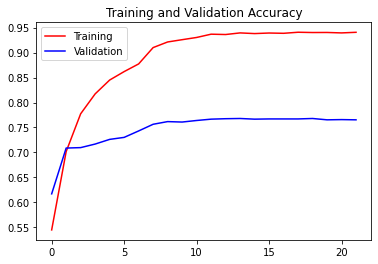

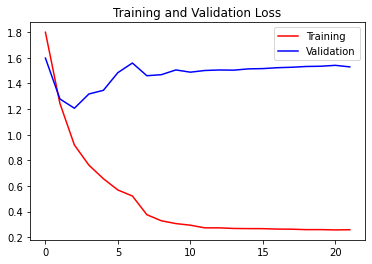

<Figure size 432x288 with 0 Axes>

In [ ]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']

epochs   = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training')
plt.plot(epochs, val_acc, 'b', label = 'Validation')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(loss))

plt.plot(epochs, loss, 'r', label = 'Training')
plt.plot(epochs, val_loss, 'b', label = 'Validation')
plt.title('Training and Validation Loss')
plt.legend()
plt.figure()

## Using LearningRateScheduler

In [ ]:
model = Sequential([
    layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM, input_length=MAX_LEN),
    layers.GlobalAveragePooling1D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

In [ ]:
optimizer   = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss        = tf.keras.losses.SparseCategoricalCrossentropy()
metrics     = ['accuracy']

In [ ]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [ ]:
early_stopping    = EarlyStopping(monitor='val_accuracy', patience=25)
lr_schedule       = LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch / 20))
model_checkpoint  = ModelCheckpoint(monitor='val_loss', filepath='./best_model.h5', save_best_only=True)

In [ ]:
EPOCHS = 100
CALLBACKS = [early_stopping, lr_schedule, model_checkpoint]

In [ ]:
history = model.fit(x_train_padded,
                    y_train,
                    epochs = EPOCHS,
                    validation_data = (x_test_padded, y_test),
                    verbose = 1,
                    callbacks = CALLBACKS)

Epoch 1/100
281/281 [==============================] - 3s 9ms/step - loss: 4.6523 - accuracy: 0.2056 - val_loss: 4.6241 - val_accuracy: 0.3629 - lr: 1.0000e-05
Epoch 2/100
281/281 [==============================] - 2s 8ms/step - loss: 4.5935 - accuracy: 0.3553 - val_loss: 4.5604 - val_accuracy: 0.3620 - lr: 1.1220e-05
Epoch 3/100
281/281 [==============================] - 2s 8ms/step - loss: 4.5237 - accuracy: 0.3536 - val_loss: 4.4833 - val_accuracy: 0.3620 - lr: 1.2589e-05
Epoch 4/100
281/281 [==============================] - 2s 7ms/step - loss: 4.4371 - accuracy: 0.3523 - val_loss: 4.3837 - val_accuracy: 0.3620 - lr: 1.4125e-05
Epoch 5/100
281/281 [==============================] - 2s 8ms/step - loss: 4.3169 - accuracy: 0.3517 - val_loss: 4.2358 - val_accuracy: 0.3620 - lr: 1.5849e-05
Epoch 6/100
281/281 [==============================] - 2s 8ms/step - loss: 4.1215 - accuracy: 0.3517 - val_loss: 3.9820 - val_accuracy: 0.3620 - lr: 1.7783e-05
Epoch 7/100
281/281 [===================

(1e-05, 0.1, 0.0, 5.0)

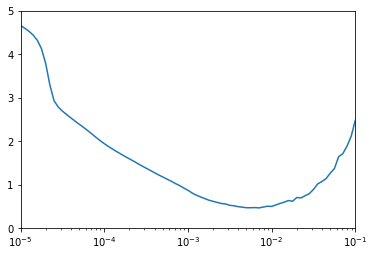

In [ ]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-5, 1e-1, 0, 5])

(1e-05, 0.1, 0.5, 0.8)

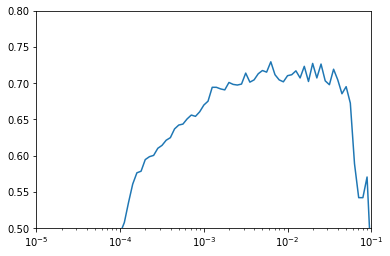

In [ ]:
plt.semilogx(history.history['lr'], history.history['val_accuracy'])
plt.axis([1e-5, 1e-1, .50, .80])

(1e-05, 0.1, 0.6, 0.95)

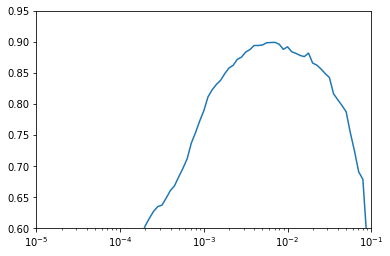

In [ ]:
plt.semilogx(history.history['lr'], history.history['accuracy'])
plt.axis([1e-5, 1e-1, .60, .95])

In [ ]:
model = Sequential([
    layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM, input_length=MAX_LEN),
    layers.GlobalAveragePooling1D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

In [ ]:
optimizer   = tf.keras.optimizers.Adam(learning_rate=2e-2)
loss        = tf.keras.losses.SparseCategoricalCrossentropy()
metrics     = ['accuracy']

In [ ]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [ ]:
early_stopping    = EarlyStopping(monitor='val_accuracy', patience=30)
model_checkpoint  = ModelCheckpoint(monitor='val_loss', filepath='./best_model.h5', save_best_only=True)

In [ ]:
EPOCHS = 150
CALLBACKS = [early_stopping, model_checkpoint]

In [ ]:
history = model.fit(x_train_padded,
                    y_train,
                    epochs = EPOCHS,
                    validation_data = (x_test_padded, y_test),
                    verbose = 1,
                    callbacks = CALLBACKS)

Epoch 1/150
281/281 [==============================] - 3s 8ms/step - loss: 1.7464 - accuracy: 0.5883 - val_loss: 1.4233 - val_accuracy: 0.6732
Epoch 2/150
281/281 [==============================] - 2s 8ms/step - loss: 1.2266 - accuracy: 0.7126 - val_loss: 1.2723 - val_accuracy: 0.7017
Epoch 3/150
281/281 [==============================] - 2s 8ms/step - loss: 0.9886 - accuracy: 0.7632 - val_loss: 1.2882 - val_accuracy: 0.7240
Epoch 4/150
281/281 [==============================] - 2s 8ms/step - loss: 0.8468 - accuracy: 0.7946 - val_loss: 1.2705 - val_accuracy: 0.7324
Epoch 5/150
281/281 [==============================] - 2s 7ms/step - loss: 0.7544 - accuracy: 0.8166 - val_loss: 1.2543 - val_accuracy: 0.7360
Epoch 6/150
281/281 [==============================] - 2s 7ms/step - loss: 0.6737 - accuracy: 0.8341 - val_loss: 1.5385 - val_accuracy: 0.7177
Epoch 7/150
281/281 [==============================] - 2s 8ms/step - loss: 0.6524 - accuracy: 0.8415 - val_loss: 1.4179 - val_accuracy: 0.7422

<Figure size 432x288 with 0 Axes>

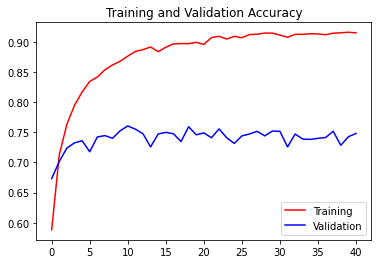

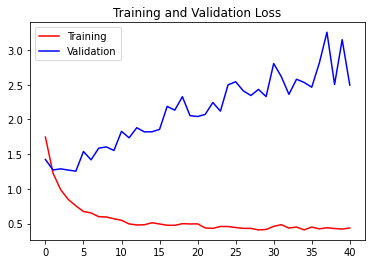

<Figure size 432x288 with 0 Axes>

In [ ]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']

epochs   = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training')
plt.plot(epochs, val_acc, 'b', label = 'Validation')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(loss))

plt.plot(epochs, loss, 'r', label = 'Training')
plt.plot(epochs, val_loss, 'b', label = 'Validation')
plt.title('Training and Validation Loss')
plt.legend()
plt.figure()

# Method 2

In [3]:
reuters = tf.keras.datasets.reuters       # keras datasets

(x_train, y_train), (x_test, y_test) = reuters.load_data()

In [4]:
VOCAB_SIZE = 20000

In [7]:
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=VOCAB_SIZE)
seq = np.concatenate((x_train, x_test), axis=0)
tokenizer.fit_on_sequences(seq)

xt_train = tokenizer.sequences_to_matrix(x_train, mode='tfidf')
xt_test = tokenizer.sequences_to_matrix(x_test, mode='tfidf')

yt_train = utils.to_categorical(y_train, num_classes = max(y_train) + 1)
yt_test = utils.to_categorical(y_test, num_classes = max(y_train) + 1)

In [13]:
x_train[:2]

array([list([1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]),
       list([1, 3267, 699, 3434, 2295, 56, 16784, 7511, 9, 56, 3906, 1073, 81, 5, 1198, 57, 366, 737, 132, 20, 4093, 7, 19261, 49, 2295, 13415, 1037, 3267, 699, 3434, 8, 7, 10, 241, 16, 855, 129, 231, 783, 5, 4, 587, 2295, 13415, 30625, 775, 7, 48, 34, 191, 44, 35, 1795, 505, 17, 12])],
      dtype=object)

In [14]:
len(x_train) + len(x_test)

11228

In [10]:
len(seq)

11228

In [11]:
seq[:2]

array([list([1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]),
       list([1, 3267, 699, 3434, 2295, 56, 16784, 7511, 9, 56, 3906, 1073, 81, 5, 1198, 57, 366, 737, 132, 20, 4093, 7, 19261, 49, 2295, 13415, 1037, 3267, 699, 3434, 8, 7, 10, 241, 16, 855, 129, 231, 783, 5, 4, 587, 2295, 13415, 30625, 775, 7, 48, 34, 191, 44, 35, 1795, 505, 17, 12])],
      dtype=object)

In [ ]:
xt_train[0]

array([0.        , 0.69310265, 0.        , ..., 0.        , 0.        ,
       0.        ])

In [18]:
xt_train[0][:100]

array([0.        , 0.69310265, 0.        , 0.        , 0.86441777,
       1.74698197, 2.5124763 , 1.93297563, 1.84755738, 0.89635166,
       0.92933835, 2.7152738 , 0.69314718, 0.        , 0.        ,
       3.4789638 , 1.88873762, 0.69645889, 0.        , 2.07493177,
       0.        , 0.        , 2.60665173, 0.        , 0.        ,
       1.27057066, 1.52202628, 0.        , 0.        , 1.39287643,
       1.43329569, 0.        , 1.40371086, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.55292725,
       0.        , 0.        , 0.        , 1.61315326, 1.55057736,
       0.        , 0.        , 0.        , 2.84178655, 1.63500027,
       0.        , 0.        , 1.72440729, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 4.05923057, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [15]:
len(xt_train[0])

20000

In [ ]:
len(xt_train)

8982

In [ ]:
yt_train[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [16]:
len(yt_train[0])

46

In [ ]:
NUM_CLASSES = len(np.unique(y_train))

In [ ]:
model = Sequential([
    layers.InputLayer(input_shape=(VOCAB_SIZE)),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 512)               10240512  
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_37 (Dense)            (None, 46)                23598     
                                                                 
Total params: 10,264,110
Trainable params: 10,264,110
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer   = 'adadelta'
loss        = tf.keras.losses.CategoricalCrossentropy()
metrics     = ['accuracy']

In [ ]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [ ]:
early_stopping    = EarlyStopping(monitor='val_accuracy', patience=8)
model_checkpoint  = ModelCheckpoint(monitor='val_loss', filepath='./best_model.h5', save_best_only=True)

In [ ]:
EPOCHS = 300
CALLBACKS = [early_stopping, model_checkpoint]

In [ ]:
history = model.fit(xt_train,
                    yt_train,
                    epochs = EPOCHS,
                    validation_data = (xt_test, yt_test),
                    verbose = 1,
                    callbacks = CALLBACKS)

Epoch 1/300
281/281 [==============================] - 4s 13ms/step - loss: 3.8770 - accuracy: 0.0351 - val_loss: 3.7825 - val_accuracy: 0.0757
Epoch 2/300
281/281 [==============================] - 3s 12ms/step - loss: 3.7477 - accuracy: 0.0970 - val_loss: 3.6611 - val_accuracy: 0.1972
Epoch 3/300
281/281 [==============================] - 3s 12ms/step - loss: 3.6257 - accuracy: 0.1874 - val_loss: 3.5456 - val_accuracy: 0.3121
Epoch 4/300
281/281 [==============================] - 3s 12ms/step - loss: 3.5076 - accuracy: 0.2806 - val_loss: 3.4338 - val_accuracy: 0.3678
Epoch 5/300
281/281 [==============================] - 3s 12ms/step - loss: 3.3899 - accuracy: 0.3524 - val_loss: 3.3261 - val_accuracy: 0.4025
Epoch 6/300
281/281 [==============================] - 3s 12ms/step - loss: 3.2792 - accuracy: 0.3843 - val_loss: 3.2230 - val_accuracy: 0.4319
Epoch 7/300
281/281 [==============================] - 3s 12ms/step - loss: 3.1849 - accuracy: 0.4105 - val_loss: 3.1243 - val_accuracy:

<Figure size 432x288 with 0 Axes>

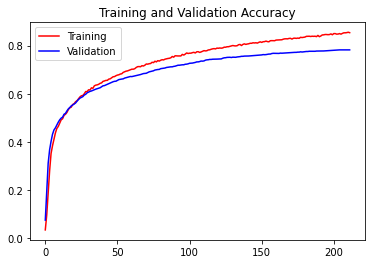

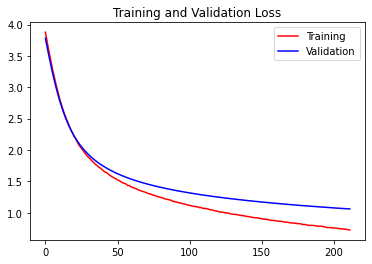

<Figure size 432x288 with 0 Axes>

In [ ]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']

epochs   = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training')
plt.plot(epochs, val_acc, 'b', label = 'Validation')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(loss))

plt.plot(epochs, loss, 'r', label = 'Training')
plt.plot(epochs, val_loss, 'b', label = 'Validation')
plt.title('Training and Validation Loss')
plt.legend()
plt.figure()